# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState
from tqdm.auto import tqdm
from scipy import stats as st

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12})
RND = 12345 
state = np.random.RandomState(12345)

In [3]:
df1 = pd.read_csv('geo_data_0.csv')
df2 = pd.read_csv('geo_data_1.csv')
df3 = pd.read_csv('geo_data_2.csv')

In [4]:
df1.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


- Все три DataSet имеют аналогичную структуру по 100_000 записей: 1 столбец с идентификатором скважины - имеет строковый тип, все оставшиеся столбцы имеют числовой тип (float64), 3 столбца целевых признаков и один целевой.
- Пропусков и дубликатов нет. 

**Анализ признака f0**

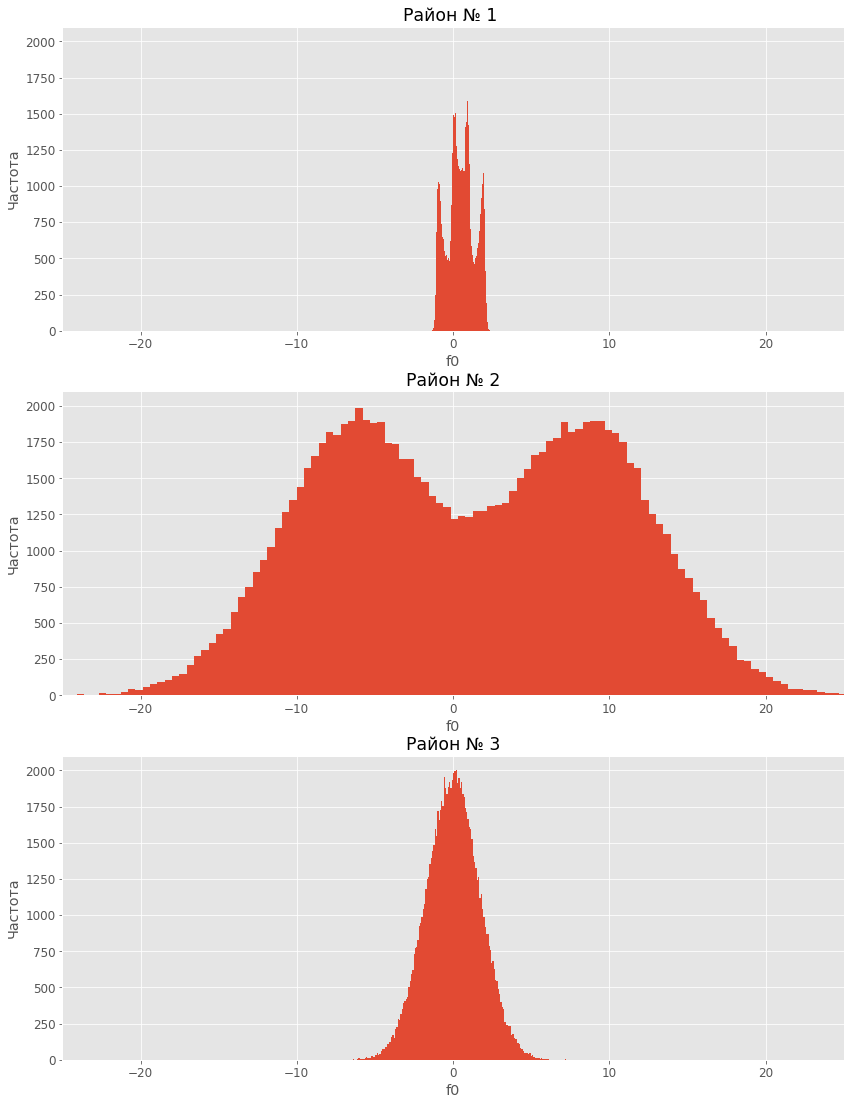

In [6]:
tmp = 'f0'
y = [0, 2100]
x = [-25, 25]
fig = plt.figure(figsize = (14,19))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 1 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df1[tmp], bins = 130)
ax2.set(xlim = x,
       ylim = y,
       title = 'Район № 2',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax2.hist(df2[tmp], bins = 130)
ax3.set(xlim = x,
       ylim = y,
       title = 'Район № 3',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax3.hist(df3[tmp], bins = 190)
plt.show()

**Анализ гистограмм для 3х месторождений для первого признака позволяет сделать следующие выводы:**
- для первого района распределение f0 гораздо более компактное чем для других районов и имеет несколько пиков, что позволяет сделать предположение, что данные f0 потенциально можно разделить на 4 кластера;
- для второго района распределение f0 имеет больший размах, наблюдается бимодальное распределение;
- для третьего района распределение f0 имеет вид весьма похожий на нормальное распределение (оценка вида распределения не проводилась). Распределение имеет один пик, что говорить о том, что данные для данного района достаточно однородные. 
Все графики представлены в одинаковом масштабе.


**Анализ признака f1**

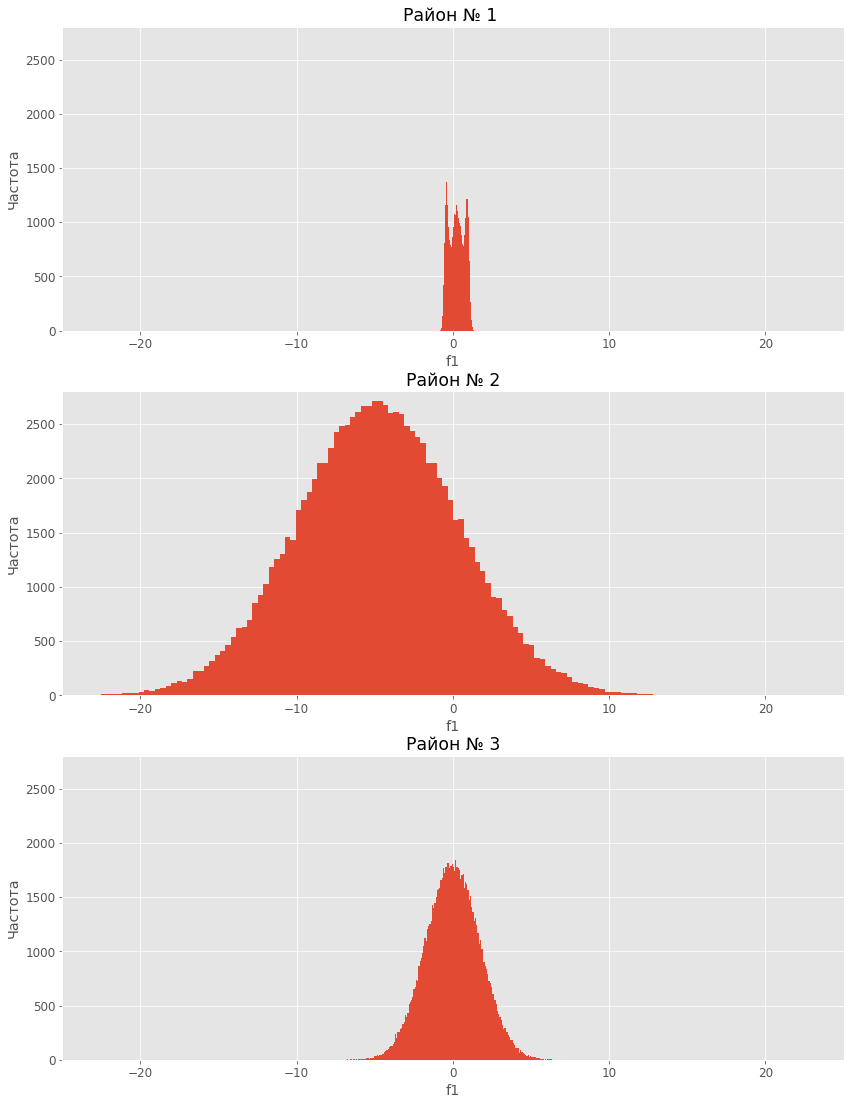

In [7]:
tmp = 'f1'
y = [0, 2800]
x = [-25, 25]
fig = plt.figure(figsize = (14,19))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 1 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df1[tmp], bins = 130)
ax2.set(xlim = x,
       ylim = y,
       title = 'Район № 2',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax2.hist(df2[tmp], bins = 130)
ax3.set(xlim = x,
       ylim = y,
       title = 'Район № 3',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax3.hist(df3[tmp], bins = 190)
plt.show()

**Анализ гистограмм для 3х месторождений для второго признака позволяет сделать следующие выводы:**
- для первого района распределение f1 гораздо более компактное чем для других районов и имеет несколько пиков, что позволяет сделать предположение, что данные f1 потенциально можно разделить на 3 кластера;
- для второго района распределение f1 имеет больший размах, наблюдается близкое к нормальному распределение;
- для третьего района распределение f1 имеет вид весьма похожий на нормальное распределение. Распределение имеет один пик, что говорить о том, что данные для данного района достаточно однородные. 

Все графики представлены в одинаковом масштабе.


**Анализ признака f2**

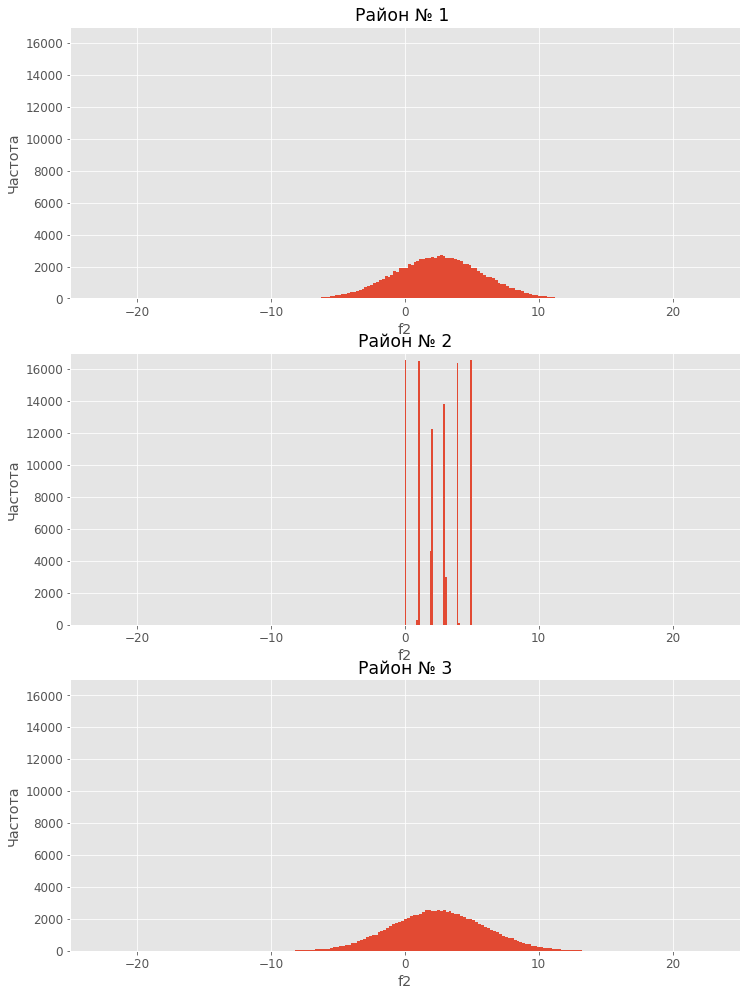

In [8]:
tmp = 'f2'
y = [0, 17000]
x = [-25, 25]
fig = plt.figure(figsize = (12,17))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 1 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df1[tmp], bins = 130)
ax2.set(xlim = x,
       ylim = y,
       title = 'Район № 2',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax2.hist(df2[tmp], bins = 40)
ax3.set(xlim = x,
       ylim = y,
       title = 'Район № 3',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax3.hist(df3[tmp], bins = 130)
plt.show()

**Анализ гистограмм для 3х месторождений для третьего признака позволяет сделать следующие выводы:**
- для первого и третьего района распределение величины f2 имеет вид близкий к нормальному распределению. 
- для второго района признак f2 имеет весьма странный вид: распределение является дискретным, что может быть связано либо с каким-то округлением, либо с другими техническими причинами, частоты практически одинаковы и имеется явно выраженный период. Если была бы возможность, то я бы обязательно узнал почему так произошло перед тем как использовать такие данные в работе. 

Ниже представлено распределение признака f2 для второго района дополнительно.


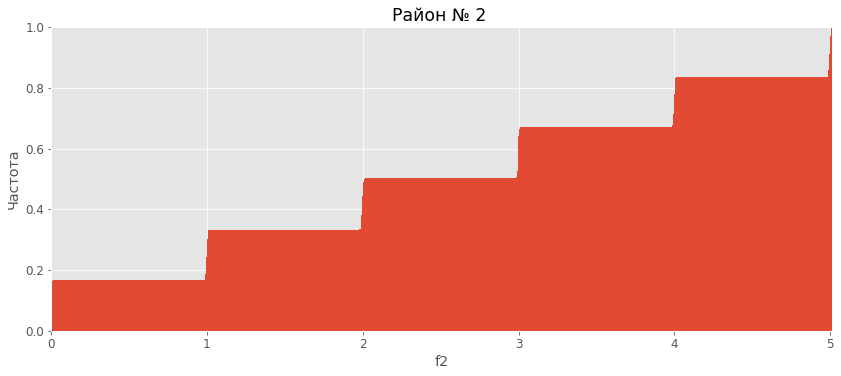

In [9]:
tmp = 'f2'
y = [0, 1]
x = [0, 5.015]
fig = plt.figure(figsize = (14,19))
ax1 = fig.add_subplot(311)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 2 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df2[tmp], bins = 1000, density=True, cumulative = True)
plt.show()

На гистограмме представлена интегральная функция распределение для параметра f2 для Района № 1. Из графика видно, что у нас "красивая лестница" с явно выраженными периодами и высотой "ступенек". Наблюдается резкое увеличение функции в точках 0, 1, 2 и до 5. Для сравнения ниже приведен аналогичный график для Района № 1. Где наблюдается практически гладкое возрастание функции распределения.

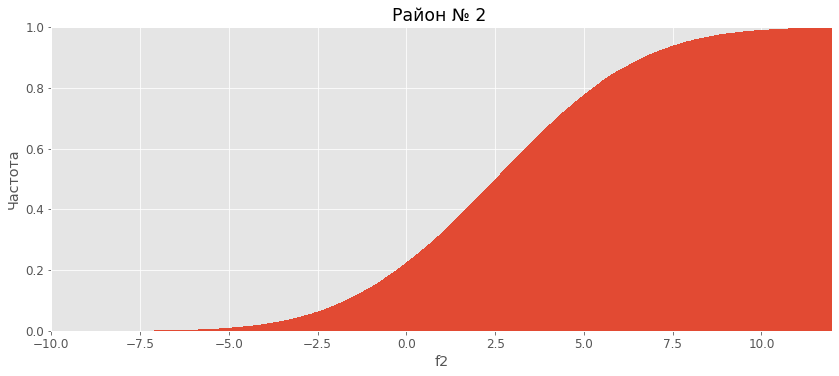

In [10]:
tmp = 'f2'
y = [0, 1]
x = [-10, 12]
fig = plt.figure(figsize = (14,19))
ax1 = fig.add_subplot(311)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 2 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df1[tmp], bins = 1000, density=True, cumulative = True)
plt.show()

**Анализ целевого признака product**

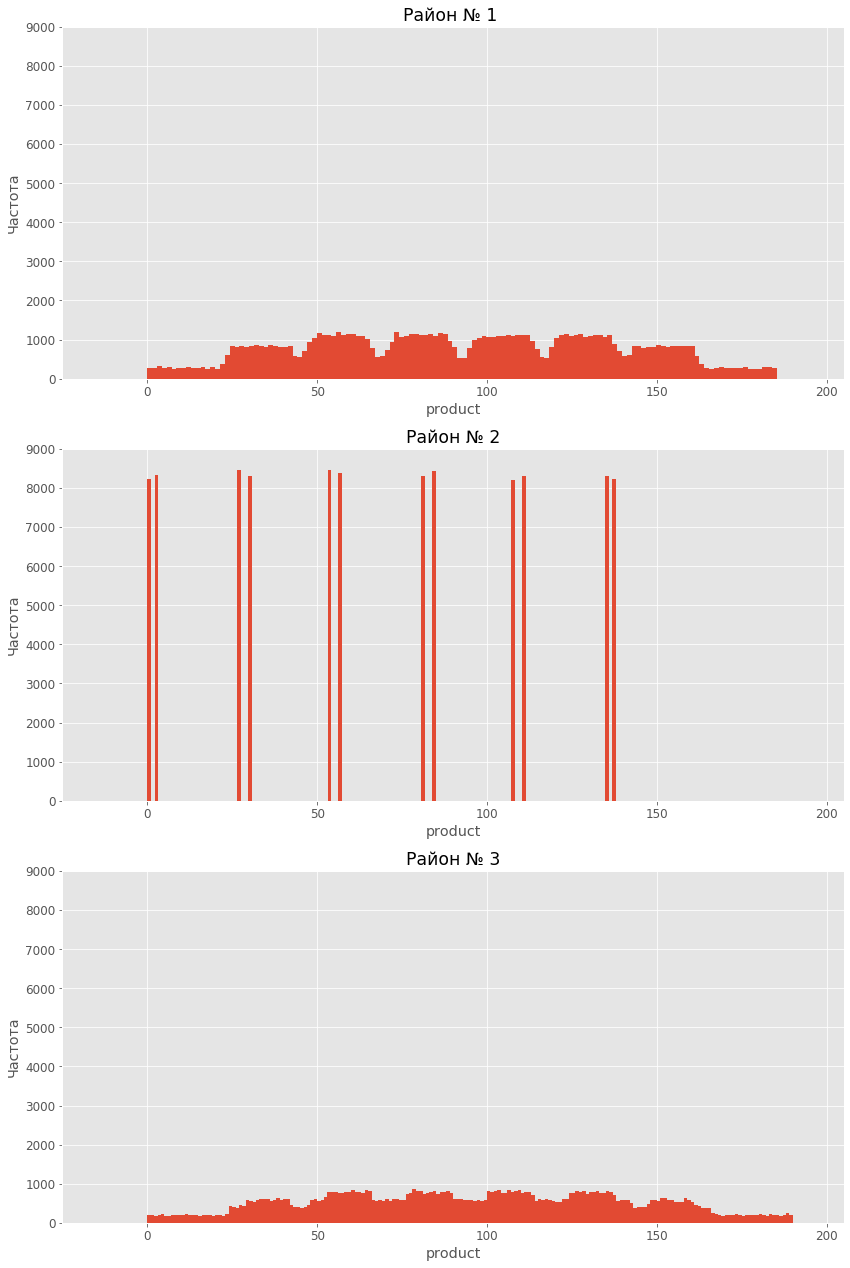

In [11]:
tmp = 'product'
y = [0, 9000]
x = [-25, 205]
fig = plt.figure(figsize = (14,22))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 1 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df1[tmp], bins = 130)
ax2.set(xlim = x,
       ylim = y,
       title = 'Район № 2',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax2.hist(df2[tmp], bins = 130)
ax3.set(xlim = x,
       ylim = y,
       title = 'Район № 3',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax3.hist(df3[tmp], bins = 190)
plt.show()

Анализ целевого признака позволяет сделать следующие выоводы: 
- первый и третий район имеет несколько пиков, что может говорить о том, что данные можно разбить на несколько групп и данные весьма неоднородные, наблюдается достаточно большой разброс значений.
- для второго района снова аномальное распределение признаков, в виду невозможности получения дополнительной информации, придется работать с такими данными. 
- в целом можно сказать, что целевой признак для всех трех районов имеет примерно одинаковый разброс значений (если представить что для второго района мы равномерно распределим значения): имеется достаточно большой разброс значений целевого признака - от 0 и до свыше 100 и даже 150, для всех трех районов можно найти скважины со значением целевого признака больше 125.


In [12]:
df1.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [13]:
df2.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [14]:
df3.corr()


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


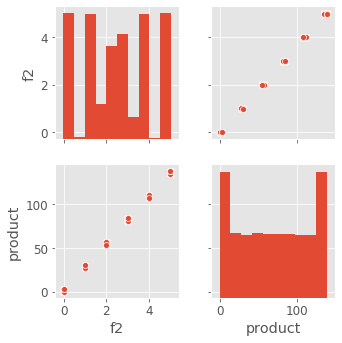

In [15]:
sns.pairplot((df2[['f2', 'product']]))

Анализ корреляции между целевым признаком и характеристиками позволяет выделить ряд интересных деталей: 
- для первого и третьего района наблюдается зависимость между f2 и целевым признаком. Данная зависимость имеет умеренный характер.
- в тоже время для второго района, для которого наблюдались аномалии для признака f2  и целевого признака, наблюдается фактически строгая прямая зависимость между f2  и целевым признаком 0.999397 - три девятки после запятой! В совокупности 3 данных факта позволяет с высокой долей предположить, что с данными возникли какие проблемы.


## Обучение и проверка модели

In [16]:
features1 = df1.drop(['id','product'], axis=1)
target1 = df1['product']
features2 = df2.drop(['id','product'], axis=1)
target2 = df2['product']
features3 = df3.drop(['id','product'], axis=1)
target3 = df3['product']

Масштабирование признаков

In [17]:
def model_fit_valid(X, y):
    """
    input: X, y - признаки и целевой признак для модели
    output: y_valid - целевой пизнак валидационной выборки 
            predict - предсказания модели на валидационной выборке
    description: функция разделяет исходные данные на обучающую и валидационную выборки (75/25),
                 обучает модель линейной регрессии, делает предсказания на валидационной выборке,
                 считает и выводит на экран среднее значение предсказаний целевого признака и RMSE модели.
    """
    #Разделили на выборку валидации и тренировочкую
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=RND)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)
    
 
    rmse = (mean_squared_error(y_valid, predict))**0.5
    predict_mean = predict.mean()
    
    print('\033[0m' +'Cредний запас предсказанного сырья:', end='' )
    print('\033[1m' + " ", round(predict_mean,1), end='')
    print('\033[0m' +' тыс. баррелей')
    print('\033[0m' +'RSME:', end='' )
    print('\033[1m' + " ", round(rmse,1), end='')
    print('\033[0m' +' тыс. баррелей')
    return y_valid, predict    

**Регион № 1**

In [18]:
y_1_valid, predict_1 = model_fit_valid(features1, target1)

Cредний запас предсказанного сырья:  92.6 тыс. баррелей
RSME:  37.6 тыс. баррелей


In [19]:
y_1f2_valid, predict_1f2 = model_fit_valid(df1[['f2']], target1)

Cредний запас предсказанного сырья:  92.6 тыс. баррелей
RSME:  38.7 тыс. баррелей


**Регион № 2** 

In [20]:
y_2_valid, predict_2 = model_fit_valid(features2, target2)

Cредний запас предсказанного сырья:  68.7 тыс. баррелей
RSME:  0.9 тыс. баррелей


In [21]:
y_2f2_valid, predict_2f2 = model_fit_valid(df2[['f2']], target2)

Cредний запас предсказанного сырья:  68.7 тыс. баррелей
RSME:  1.6 тыс. баррелей


**Регион № 3**

In [22]:
y_3_valid, predict_3 = model_fit_valid(features3, target3)

Cредний запас предсказанного сырья:  95.0 тыс. баррелей
RSME:  40.0 тыс. баррелей


In [23]:
y_3f2_valid, predict_3f2 =model_fit_valid(df3[['f2']], target3)

Cредний запас предсказанного сырья:  95.0 тыс. баррелей
RSME:  40.0 тыс. баррелей


In [24]:
df_rez = pd.DataFrame({'region1_predict':predict_1,\
                       'region2_predict':predict_2,\
                       'region3_predict':predict_3,})

Анализ моделей для прогнозирования целевого признака позволяет сделать следующие выводы:
- средние запасы нефти для региона № 1 и региона № 3 выше, чем для региона № 2.
- при этом прогноз для региона на основе линейной регрессии по критерию среднеквадратичной ошибки для региона № 2 значительно более точный, что не удивительно, если учесть зависимость между f2 и целевым признаком;
- прогноз при использовании только признака f2 показал значительно лучшие результаты чем прогнозирования для региона № 1 и региона № 3, но немного хуже, чем при использовании всех 3-х признаков, таким образом, вклад f2 в прогнозирование для второго региона подавляющий;
- прогнозирование для региона № 1 и региона № 3 только по признаку f2 дает аналогичную картину; 
- вклад признаков f0,  f1 имеет не очень большое значение для точности прогнозирования.




## Подготовка к расчёту прибыли

In [25]:
BUDGET = 10_000_000_000 #Бюджет на разработку скважин в регионе
SAMP_WELLS = 500 # объем разведки в регионе скважен, шт.
TOP_WELLS = 200 # объем добычи в регионе скважен, шт.
UNIT_INCOME = 450_000 # прибыль с каждой 1000 баррелей, рублей
MAX_RISK = 0.025 # требуемая вероятность убытков (не более) 
payback_threshold = BUDGET/(TOP_WELLS*UNIT_INCOME) 
print('Порог окупаемости, тыс. барралей с одной скважены:'+'\033[1m',round(payback_threshold,1))

Порог окупаемости, тыс. барралей с одной скважены: 111.1


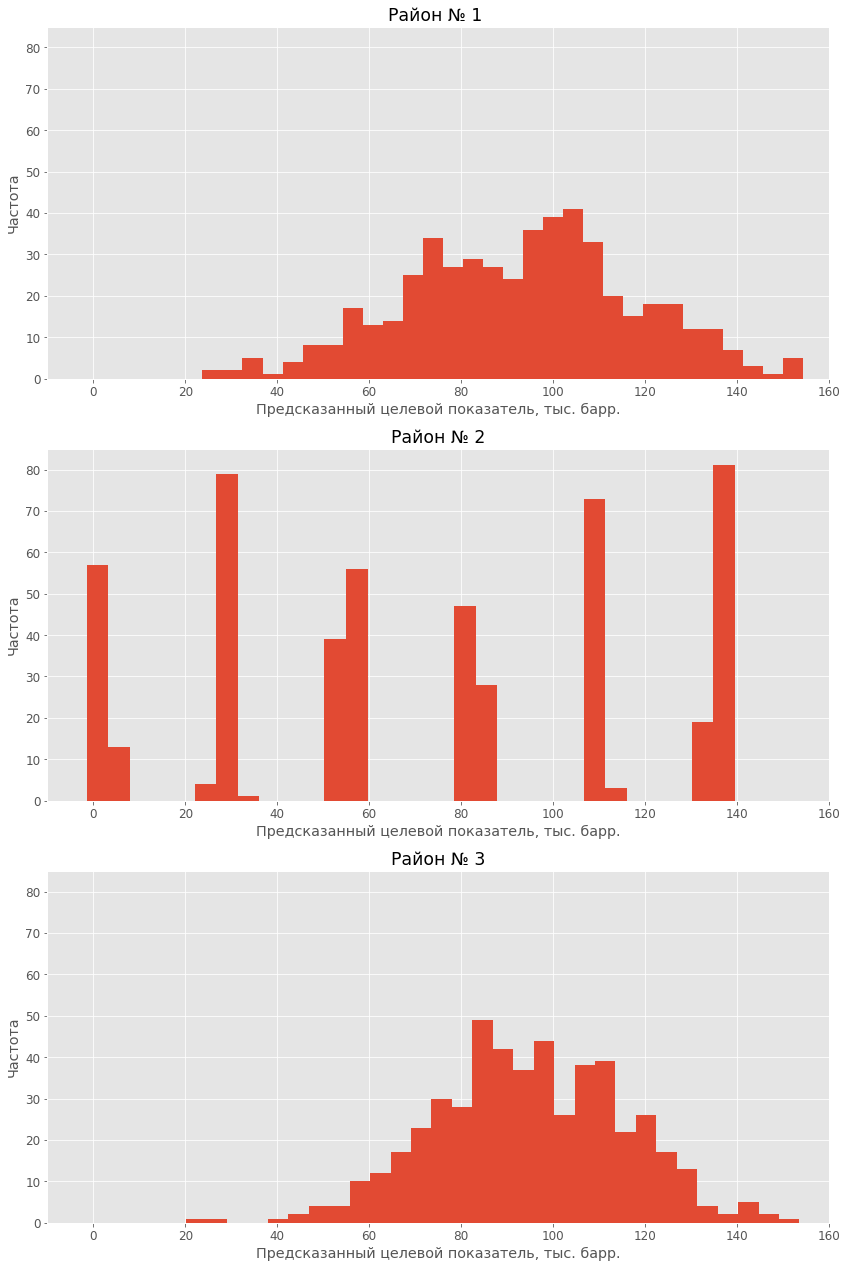

In [27]:
tmp = 'Предсказанный целевой показатель, тыс. барр.'
y = [0, 85]
x = [-10, 160]
fig = plt.figure(figsize = (14,22))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
ax1.set(xlim = x,
       ylim = y,
       title = 'Район № 1 ',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax1.hist(df_rez['region1_predict'].sample(500, random_state = RND), bins = 30)
ax2.set(xlim = x,
       ylim = y,
       title = 'Район № 2',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax2.hist(df_rez['region2_predict'].sample(500, random_state = RND), bins = 30)
ax3.set(xlim = x,
       ylim = y,
       title = 'Район № 3',
       xlabel = tmp,
       ylabel = 'Частота'
       )
ax3.hist(df_rez['region3_predict'].sample(500, random_state = RND), bins = 30)
plt.show()

In [28]:
df_rez[['region1_predict','region2_predict', 'region3_predict' ]].sample(500, random_state = RND).describe()


,region1_predict,region2_predict,region3_predict
count,500.000000,500.000000,500.000000
mean,92.928155,71.838213,94.731096
std,24.712770,46.045549,20.639081
min,23.723281,-1.461433,20.189540
25%,75.392630,29.411487,80.792515
50%,95.295902,80.148369,94.202937
75%,109.018406,110.176424,109.510608
max,154.489037,139.560938,153.650598


При анализе гистограмм и статистик можно сделать следующие выводы:
- 1-й и 3-й регион обладают большими средними, и имеют схожее с нормальным распределением. Нормальное распределение характеризуется достаточно быстро убывающими хвостами, в тоже время 2-й регион, несмотря на дискретный характер, имеет "равномерное" распределение. И, несмотря на то что в 1-й и 3-й регион обладает большими средними значениями целевого показателя, во 2-м регионе есть 1/3 скважин со средним значением значительно больше 111, которое требуется для окупаемости.
- сравнивая 75-ю квартиль и медианы для регионов можно потвердеть предыдущий вывод: если медиана для 2-го региона самая маленькая, то 75-я квартиль уже самая большая и оставшаяся 1/4 скважин 2-го региона выводит его вперед;
- хотя 1-й и 3-й регион также имеют максимальные значения по выборкам, но за счет того, что хвосты достаточно легкие в нормальном распределении, то они не позволяют обойти 2-й регион с псевдоравномерным распределением.


In [29]:
print('Среднее количество нефти для 1-го региона, тыс. баррелей на скважену :', end='')
print('\033[1m {:.1f}'.format((df_rez['region1_predict'].sample(500, random_state = RND).sort_values(ascending = False).head(200).mean())))     
print('\033[0m'+'Среднее количество нефти для 2-го региона, тыс. баррелей на скважену :', end='')
print('\033[1m {:.1f}'.format((df_rez['region2_predict'].sample(500, random_state = RND).sort_values(ascending = False).head(200).mean()))) 
print('\033[0m'+'Среднее количество нефти для 3-го региона, тыс. баррелей на скважену :', end='')
print('\033[1m {:.1f}'.format((df_rez['region3_predict'].sample(500, random_state = RND).sort_values(ascending = False).head(200).mean()))) 

Среднее количество нефти для 1-го региона, тыс. баррелей на скважену : 116.7
Среднее количество нефти для 2-го региона, тыс. баррелей на скважену : 119.8
Среднее количество нефти для 3-го региона, тыс. баррелей на скважену : 114.9


- Расчет показал, что для окупаемости добычи нефти в регионе требуется при проведённой разведке по 500 скважинам и выборе 200 лучших и бюджете 10 млрд. рублей и прибыли с каждой баррели 450 рублей, получаем, что нужно добывать в среднем в каждой из 200 скважин около 111 тыс. баррелей. 
- Случайная выборка 500 скважин с последующим отбором 200 лучших, показала, что все регионы обеспечивают выход на прибыль.

In [30]:
# функция рассчета прибыли по 200 скважинам каждого региона, 
# наилучших по прогнозу объема нефти.
def profit(target, probabilities):
    target = pd.Series(target).reset_index(drop=True)
    probabilities = pd.Series(probabilities).reset_index(drop=True)
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:TOP_WELLS]
    return (UNIT_INCOME * selected.sum() - BUDGET)/1_000_000

## Расчёт прибыли и рисков 

In [33]:
def bootstrap (target, predictions):
    values = []
    for i in tqdm(range(1000)): #добавил progressbar чтобы смотреть было приятнее
        target_subsample = target.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        probs_subsample = predictions[target_subsample.index]
        prof = profit(target_subsample, probs_subsample) #расчет прибыли
        values.append(prof)

    values = pd.Series(values)
    lower = values.quantile(0.025) #нижняя граница доверительного интервала
    high = values.quantile(0.975) #верхняя граница доверительного интервала
    #построение гистограммы    
    fig = plt.figure(figsize = (7,11))
    ax1 = fig.add_subplot(311)
    ax1.set(title = 'Функция распределения прибыли',
           xlabel = 'Прибыль, млн. рублей',
           ylabel = 'Частота'
           )
    ax1.hist(values, bins = 30)
    

    #вывод 
    print("Средняя выручка, млн. рублей:", int(values.mean()))
    print("Доверительный интервал, млн. рублей:", round(lower,0),' - ', round(high, 0) )
    print('Выборочное стандартное отклонение прибыли, млн. рублей',round(values.sem(),1))
    if (values < 0).mean()<=MAX_RISK:
        print("\033[32m"+"\033[12mРиск убытка:", round((values < 0).mean()*100,2), '%')
        print('Риск убытка ниже заданной виличнины,', MAX_RISK*100, ' %')
    else:
        print("\033[31m"+"Риск убытка:", round((values < 0).mean()*100,2), '%')
        print('Риск убытка выше заданной виличнины', MAX_RISK*100, ' %')
    
 


Средняя выручка, млн. рублей: 391
Доверительный интервал, млн. рублей: -143.0  -  889.0
Выборочное стандартное отклонение прибыли, млн. рублей 8.6
Риск убытка: 7.0 %
Риск убытка выше заданной виличнины 2.5  %


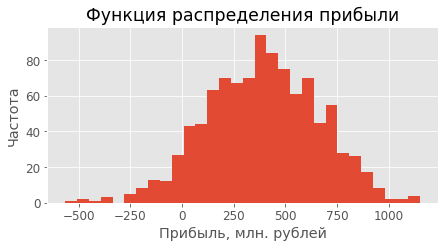

In [34]:
bootstrap(y_1_valid, predict_1)


Средняя выручка, млн. рублей: 447
Доверительный интервал, млн. рублей: 82.0  -  836.0
Выборочное стандартное отклонение прибыли, млн. рублей 6.2
Риск убытка: 1.2 %
Риск убытка ниже заданной виличнины, 2.5  %


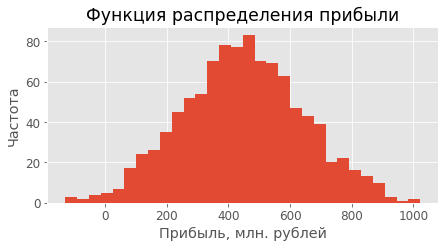

In [35]:
bootstrap(y_2_valid, predict_2)



Средняя выручка, млн. рублей: 395
Доверительный интервал, млн. рублей: -89.0  -  887.0
Выборочное стандартное отклонение прибыли, млн. рублей 8.3
Риск убытка: 5.7 %
Риск убытка выше заданной виличнины 2.5  %


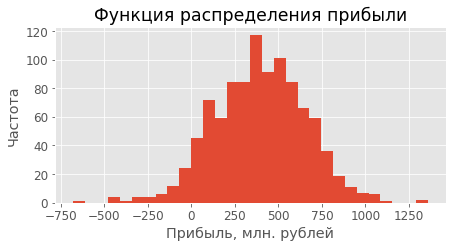

In [36]:
bootstrap(y_3_valid, predict_3)

- Произведен расчет экономических показателей для трех районов;
- Требуемое значения по риску убытка удовлетворяет только второй регион со значением риска - 0,7 %;
- Средняя вырочка также максимальна для второго региона со значением 461 млн. рублей.
- Таким образом, для разработки может быть рекомендован только регион № 2.
- Преимущество региона № 2 над другими региона обеспечивается в том числе за счет меньшего стандартного отклоения прибыли, что снижает риски убытков.

## Общий вывод

- Анализ целевого признака позволяет сделать следующие выводы: 
    - первый и третий район имеет несколько пиков, что может говорить о том, что данные можно разбить на несколько групп и данные весьма неоднородные, наблюдается достаточно большой разброс значений.
    - для второго района аномальное распределение признаков - распределение имеет дискретный вид. 
    - в целом можно сказать, что целевой признак для всех трех районов имеет примерно одинаковый разброс значений: имеется достаточно большой разброс значений целевого признака - от 0 и до свыше 100 и даже 150, для всех трех районов можно найти скважины со значением целевого признака больше 125.
- Анализ корреляции между целевым признаком и характеристиками позволяет выделить ряд интересных деталей: 
    - для первого и третьего района наблюдается зависимость между f2 и целевым признаком. Данная зависимость имеет умеренный характер.
    - в тоже время для второго района, для которого наблюдались аномалии для признака f2  и целевого признака, наблюдается фактически строгая прямая зависимость между f2  и целевым признаком 0.999397 - три девятки после запятой! 
- Анализ моделей для прогнозирования целевого признака позволяет сделать следующие выводы:
    - средние запасы нефти для региона № 1 и региона № 3 выше, чем для региона № 2.
    - при этом прогноз для региона на основе линейной регрессии по критерию среднеквадратичной ошибки для региона № 2 значительно более точный, что не удивительно, если учесть зависимость между f2 и целевым признаком;
    - прогноз при использовании только признака f2 показал значительно лучшие результаты чем прогнозирования для региона № 1 и региона № 3, но немного хуже, чем при использовании всех 3-х признаков, таким образом, вклад f2 в прогнозирование для второго региона подавляющий;прогнозирование для региона № 1 и региона № 3 только по признаку f2 дает аналогичную картину; вклад признаков f0,  f1 имеет не очень большое значение.
- Анализ гистограмм и статистик прогнозов целевого признака:
    - 1-й и 3-й регион обладают большими средними, и имеют схожее с нормальным распределением. Нормальное распределение характеризуется достаточно быстро убывающими хвостами, в тоже время 2-й регион, несмотря на дискретный характер, имеет "равномерное" распределение. И, несмотря на то что в 1-й и 3-й регион обладает большими средними значениями целевого показателя, во 2-м регионе есть 1/3 скважин со средним значением значительно больше 111, которое требуется для окупаемости.
    - сравнивая 75-ю квартиль и медианы для регионов можно потвердеть предыдущий вывод: если медиана для 2-го региона самая маленькая, то 75-я квартиль уже самая большая и оставшаяся 1/4 скважин 2-го региона выводят его вперед;
 - Расчет показал, что для окупаемости добычи нефти в регионе требуется около 111 тыс. баррелей в среднем с каждой скважены. 
 - Случайная выборка 500 скважин с последующим отбором 200 лучших, показала, что все регионы обеспечивают окупаемость добычи:
    - Среднее количество нефти для 1-го региона, тыс. баррелей на скважену : 116.7.
    - Среднее количество нефти для 2-го региона, тыс. баррелей на скважену : 119.8
    - Среднее количество нефти для 3-го региона, тыс. баррелей на скважену : 114.9
- Произведен расчет экономических показателей для трех районов;
    - Требуемому значению риска убытка удовлетворяет только второй регион со значением риска - 0,7 %;
    - Средняя вырочка также максимальна для второго региона со значением 461 млн. рублей.
    - Таким образом, для разработки может быть рекомендован только регион № 2.
    - преимущество региона № 2 над другими региона обеспечивается в том числе за счет меньшего стандартного отклоения прибыли, что снижает риски убытков.
- Все региона обеспечивают получение прибыли от добычи нефти, но риск добычи в регионе № 2 удовлетовряет требованиям и минимальный


